<a href="https://colab.research.google.com/github/lucasyanm/dm_evaluation_ai/blob/main/Fixed_Priority_Deadline_Monotonic_Schedule_Analysis_with_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tagger
The exact function to label a set of tasks as schedulable / not schedulable.

In [ ]:
import math
from typing import List

def is_schedulable_rta(C: List[float], T: List[float], D: List[float]=None, max_iter=1000) -> bool:
    """
    Exact RTA for fixed priority (assumes Deadline Monotonic: shorter period -> higher priority).
    Returns True if the entire set is schedulable.
    """
    n = len(C)
    if D is None:
        D = T.copy()

    # order by ascending period (DM priority)
    idx = sorted(range(n), key=lambda i: T[i])
    C_ord = [C[i] for i in idx]
    T_ord = [T[i] for i in idx]
    D_ord = [D[i] for i in idx]

    for k in range(n):
        R_prev = C_ord[k]
        converged = False
        for _ in range(max_iter):
            interference = 0.0
            for i in range(k):  # only higher priority tasks
                interference += math.ceil(R_prev / T_ord[i]) * C_ord[i]
            R = C_ord[k] + interference
            if R > D_ord[k]:
                return False
            if R == R_prev:
                converged = True
                break
            R_prev = R
        if not converged:
            return False
    return True

##Quick Test

In [ ]:
# quick example
if __name__ == "__main__":
    # execution time set
    C = [1.0, 2.0, 1.5]
    # period set
    T = [10.0, 20.0, 30.0]
    print("Schedulable?", is_schedulable_rta(C, T))

Schedulable? True


# UUniFast and Dataset Generator

In [ ]:
import random
import numpy as np
from torch.utils.data import Dataset

def uunifast(total_u: float, n: int) -> list:
    utilizations = []
    sum_u = total_u
    for i in range(1, n):
        next_u = sum_u * (1.0 - random.random() ** (1.0/(n - i)))
        utilizations.append(next_u)
        sum_u -= next_u
    utilizations.append(sum_u)
    return utilizations

# The total samples are n_samples * 10 to have the same quantity of groups for total utilization
class TasksetDataset(Dataset):
    def __init__(self, n_samples: int, min_tasks=3, max_tasks=12,
                 util_range=(0.05, 1), period_range=(10, 1000), seed=0):
        random.seed(seed); np.random.seed(seed)
        self.samples = []
        for _ in range(n_samples):
          # creating tasks
          n = random.randint(min_tasks, max_tasks)

          for total_u in np.round(np.arange(0.1, 1.1, 0.1),1):
              # print("total u:", total_u)
              utilizationSet = uunifast(total_u, n)
              periodSet = np.exp(np.random.uniform(np.log(period_range[0]), np.log(period_range[1]), size=n))
              executionTimeSet = [max(1e-8, u * T) for u, T in zip(utilizationSet, periodSet)]

              label = float(is_schedulable_rta(executionTimeSet, list(periodSet)))
              tasks = np.stack([np.array(executionTimeSet, dtype=np.float32), np.array(periodSet, dtype=np.float32)], axis=1)
              self.samples.append((tasks, label))

    def __len__(self):
        return len(self.samples)

    #it calls this method in any interation due to torch dataset inheritance
    def __getitem__(self, idx):
        return self.samples[idx]

##Quick test

In [ ]:
if __name__ == "__main__":
    ds = TasksetDataset(n_samples = 5)
    for t, y in ds:
        print(t.shape, y)

(9, 2) 1.0
(9, 2) 1.0
(9, 2) 1.0
(9, 2) 1.0
(9, 2) 1.0
(9, 2) 1.0
(9, 2) 1.0
(9, 2) 1.0
(9, 2) 1.0
(9, 2) 0.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 0.0
(7, 2) 1.0
(7, 2) 1.0
(7, 2) 1.0
(7, 2) 1.0
(7, 2) 1.0
(7, 2) 1.0
(7, 2) 1.0
(7, 2) 1.0
(7, 2) 1.0
(7, 2) 0.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 1.0
(11, 2) 0.0
(12, 2) 1.0
(12, 2) 1.0
(12, 2) 1.0
(12, 2) 1.0
(12, 2) 1.0
(12, 2) 1.0
(12, 2) 1.0
(12, 2) 1.0
(12, 2) 1.0
(12, 2) 0.0


#Dataloader
This `collate_fn` allows to use task sets of different sizes in the same batch. The mask is crucial for attention (to ignore padding positions).

In [ ]:
import torch
import numpy as np

def collate_tasksets(batch):
    """
    batch: list of (tasks: np.array [n_i, 2], label: float)
    Returns:
      padded_tasks: tensor [B, Nmax, 2]
      mask: bool tensor [B, Nmax] (True where it has data)
      labels: tensor [B]
    """
    tasks_list, labels = zip(*batch)
    B = len(tasks_list)
    lengths = [t.shape[0] for t in tasks_list]
    Nmax = max(lengths)
    padded = np.zeros((B, Nmax, 2), dtype=np.float32)
    mask = np.zeros((B, Nmax), dtype=np.bool_)
    for i, t in enumerate(tasks_list):
        L = t.shape[0]
        padded[i, :L, :] = t
        mask[i, :L] = True
    return torch.from_numpy(padded), torch.from_numpy(mask), torch.tensor(labels, dtype=torch.float32)

##Normalization

In [ ]:
def collate_tasksets_normalized(batch):
    padded, mask, labels = collate_tasksets(batch)
    # normalize periods using log
    periods = padded[..., 1]
    logT = torch.log1p(periods)
    C = padded[..., 0]

    # scale C with T -> C_rel = C/T (avoid large variations)
    C_rel = C / (periods + 1e-8)

    # concat features: [C, T_log, C_rel]
    feats = torch.stack([C, logT, C_rel], dim=-1)  # now shape [B, N, 3]

    # compute aggregated features per set
    n_tasks = mask.sum(dim=1, keepdim=True).float()  # [B,1]
    total_util = (C_rel * mask.float()).sum(dim=1, keepdim=True)  # [B,1]
    agg = torch.cat([n_tasks, total_util], dim=1)  # [B,2]
    return feats, mask, labels, agg

#Minimal Implementation of Set Transformer
MAB, SAB and PMA

In [ ]:
import torch
import torch.nn as nn

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=True):
        super().__init__()
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        self.attn = nn.MultiheadAttention(embed_dim=dim_V, num_heads=num_heads, batch_first=True)
        self.fc_o = nn.Linear(dim_V, dim_V)
        self.ln1 = nn.LayerNorm(dim_V) if ln else nn.Identity()
        self.ln2 = nn.LayerNorm(dim_V) if ln else nn.Identity()
        self.ff = nn.Sequential(nn.Linear(dim_V, dim_V), nn.ReLU(), nn.Linear(dim_V, dim_V))

    def forward(self, Q, K, mask_K=None, return_attn=False):
        q = self.fc_q(Q)
        k = self.fc_k(K)
        v = self.fc_v(K)
        key_padding_mask = None

        if mask_K is not None:
            key_padding_mask = ~mask_K
        attn_out, attn_weights = self.attn(q, k, v, key_padding_mask=key_padding_mask, need_weights=True)
        out = self.ln1(Q + self.fc_o(attn_out))
        out2 = self.ln2(out + self.ff(out))

        if return_attn:
            return out2, attn_weights  # attn_weights shape [B, qn, kn] or as returned
        return out2

class ISAB(nn.Module):
    def __init__(self, dim, num_heads, num_inducing, ln=True):
        super().__init__()
        self.I = nn.Parameter(torch.randn(1, num_inducing, dim))
        self.mab1 = MAB(dim_Q=self.I.shape[-1], dim_K=dim, dim_V=dim, num_heads=num_heads, ln=ln)
        self.mab2 = MAB(dim_Q=dim, dim_K=self.I.shape[-1], dim_V=dim, num_heads=num_heads, ln=ln)
    def forward(self, X, mask=None):
        B = X.shape[0]
        I_rep = self.I.expand(B, -1, -1)
        H = self.mab1(I_rep, X, mask_K=mask)
        return self.mab2(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds=1, ln=True):
        super().__init__()
        self.S = nn.Parameter(torch.randn(1, num_seeds, dim))
        self.mab = MAB(dim_Q=self.S.shape[-1], dim_K=dim, dim_V=dim, num_heads=num_heads, ln=ln)
    def forward(self, X, mask=None):
        B = X.shape[0]
        S_rep = self.S.expand(B, -1, -1)
        return self.mab(S_rep, X, mask_K=mask)

class SetTransformer(nn.Module):
    def __init__(self, input_dim=3, dim=128, num_heads=4, num_inds=32, num_sab=2, pool_seeds=1, agg_dim=2):
        super().__init__()
        self.embed = nn.Sequential(nn.Linear(input_dim, dim), nn.ReLU(), nn.LayerNorm(dim))
        self.encoder = nn.ModuleList([ISAB(dim=dim, num_heads=num_heads, num_inducing=num_inds) for _ in range(num_sab)])
        self.pma = PMA(dim=dim, num_heads=num_heads, num_seeds=pool_seeds)
        self.classifier = nn.Sequential(
            nn.Linear(
                dim * pool_seeds + agg_dim, dim//2),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(dim//2, 1)
          )

    def forward(self, x, mask=None, agg=None):
        h = self.embed(x)
        for layer in self.encoder:
            h = layer(h, mask=mask)
        pooled = self.pma(h, mask=mask)
        pooled = pooled.view(pooled.shape[0], -1)
        if agg is not None:
            pooled = torch.cat([pooled, agg.to(pooled.device)], dim=1)
        logit = self.classifier(pooled).squeeze(1)
        return logit

#Training and Inference Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def get_accuracy_rate(ys, preds):
    """
    Calculate various accuracy metrics from true and predicted labels.
    """
    # Calculate confusion matrix for the current bin
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(
        ys, preds, labels=[0, 1]).ravel()

    # True Positive Rate (Sensitivity/Recall)
    true_positive_rate = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0

    # False Positive Rate (FPR)
    false_positive_rate = false_positive / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0.0

    # True Negative Rate (TNR)
    true_negative_rate = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0.0

    # Overall Accuracy
    accuracy = accuracy_score(ys, preds)

    return true_positive_rate, false_positive_rate, true_negative_rate, accuracy

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def train_epoch(model, loader, optim, device, pos_weight=None):
    model.train()
    losses = []
    if pos_weight is None:
        crit = nn.BCEWithLogitsLoss()
    else:
        crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=device))
    for feats, mask, labels, agg in loader:

        feats = feats.to(device)
        mask = mask.to(device)
        labels = labels.to(device)
        agg = agg.to(device)

        optim.zero_grad()
        logits = model(feats, mask=mask, agg=agg)
        loss = crit(logits, labels)
        loss.backward()
        optim.step()
        losses.append(loss.item())

    return float(np.mean(losses))

def evaluate(model, dataloader, device):
    model.eval()
    ys = []
    preds = []
    probs = []
    all_aggs = [] # Initialize all_aggs here
    with torch.no_grad():
        for batch in dataloader:
            # Corrected unpacking order: feats, mask, labels, agg
            feats, mask, labels, agg = batch

            feats = feats.to(device)
            mask = mask.to(device)
            labels = labels.to(device)
            agg = agg.to(device)

            logits = model(feats, mask=mask, agg=agg)
            p = torch.sigmoid(logits)

            pred = (p >= 0.5).long()
            preds.extend(pred.cpu().numpy().tolist())
            probs.extend(p.cpu().numpy().tolist())

            ys.extend(labels.cpu().numpy().tolist())
            all_aggs.extend(agg.cpu().numpy()) # Append agg to all_aggs

    # compute metrics
    # acc = accuracy_score(ys, preds)
    prec = precision_score(ys, preds, zero_division=0)
    rec = recall_score(ys, preds, zero_division=0)
    f1 = f1_score(ys, preds, zero_division=0)
    try:
        auc = roc_auc_score(ys, probs)
    except Exception:
        auc = float("nan")

    # Calculate confusion matrix components
    tpr, fpr, tnr, acc = get_accuracy_rate(ys, preds)

    metrics_dict = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "tpr": tpr,
        "fpr": float(fpr),
        "tnr": float(tnr)
        }
    return metrics_dict, ys, preds, all_aggs

def compute_pos_weight(dataset):
    # calculates pos_weight = N_neg / N_pos for BCEWithLogitsLoss
    labels = [s[1] for s in dataset.samples]
    neg = sum(1 for l in labels if l == 0.0)
    pos = sum(1 for l in labels if l == 1.0)
    if pos == 0:
        return 1.0
    return neg / pos

#Main

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_by_utilization(ys, preds, all_aggs, bins=np.arange(0.0, 1.01, 0.05)):
    """
    Plots True Positive Rate, True Negative Rate, and False Positive Rate across utilization bins.

    Args:
        ys (list or np.array): True labels.
        preds (list or np.array): Predicted labels.
        all_aggs (list or np.array): Aggregated features, where the second column is total utilization.
        bins (np.array): Array defining the edges of the utilization bins.
    """
    ys = np.array(ys)
    preds = np.array(preds)
    all_aggs = np.array(all_aggs)

    # Extract total utilization (second column of agg, index 1)
    total_utilizations = all_aggs[:, 1]

    tpr_per_bin = []
    fpr_per_bin = []
    tnr_per_bin = []
    acc_per_bin = []
    bin_centers = []

    for i in range(len(bins) - 1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        bin_centers.append((lower_bound + upper_bound) / 2)

        # Find samples within the current utilization bin
        mask = (total_utilizations >= lower_bound) & (total_utilizations < upper_bound)
        bin_ys = ys[mask]
        bin_preds = preds[mask]

        if len(bin_ys) > 0:
          tpr, fpr, tnr, acc = get_accuracy_rate(bin_ys, bin_preds)

          tpr_per_bin.append(tpr)
          fpr_per_bin.append(fpr)
          tnr_per_bin.append(tnr)
          acc_per_bin.append(acc)
        else:
            # If no samples in bin, append NaN or 0 for metrics
            tpr_per_bin.append(np.nan)
            fpr_per_bin.append(np.nan)
            tnr_per_bin.append(np.nan)
            acc_per_bin.append(np.nan)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(
        bin_centers,
        acc_per_bin,
        label='Overall Accuracy',
        marker='^')
    plt.plot(
        bin_centers,
        tpr_per_bin,
        label='True Positive Rate (TPR)',
        marker='o')
    plt.plot(
        bin_centers,
        fpr_per_bin,
        label='False Positive Rate (FPR)',
        marker='s')
    plt.plot(
        bin_centers,
        tnr_per_bin,
        label='True Negative Rate (TNR)',
        marker='x')

    plt.xlabel('Total Utilization Bin')
    plt.ylabel('Metric Value')
    plt.title('Model Performance by Total Utilization (Test Set)')
    plt.legend()
    plt.grid(True)
    plt.xticks(bins[::2]) # Show fewer x-ticks for better readability
    plt.tight_layout()
    plt.show()

pos_weight: 0.1250960550757021
Epoch 01  TrainLoss: 0.0370  ValF1: 0.9519  ValAcc: 0.9185
Epoch 02  TrainLoss: 0.0145  ValF1: 0.9928  ValAcc: 0.9873
Epoch 03  TrainLoss: 0.0120  ValF1: 0.9938  ValAcc: 0.9891
Epoch 04  TrainLoss: 0.0113  ValF1: 0.9757  ValAcc: 0.9578
Epoch 05  TrainLoss: 0.0106  ValF1: 0.9909  ValAcc: 0.9839
Epoch 06  TrainLoss: 0.0106  ValF1: 0.9906  ValAcc: 0.9834
Epoch 07  TrainLoss: 0.0102  ValF1: 0.9876  ValAcc: 0.9782
Epoch 08  TrainLoss: 0.0088  ValF1: 0.9870  ValAcc: 0.9772
Epoch 09  TrainLoss: 0.0088  ValF1: 0.9925  ValAcc: 0.9867
Epoch 10  TrainLoss: 0.0087  ValF1: 0.9851  ValAcc: 0.9739
Epoch 11  TrainLoss: 0.0086  ValF1: 0.9901  ValAcc: 0.9825
Epoch 12  TrainLoss: 0.0080  ValF1: 0.9875  ValAcc: 0.9781
Epoch 13  TrainLoss: 0.0079  ValF1: 0.9857  ValAcc: 0.9749
Epoch 14  TrainLoss: 0.0078  ValF1: 0.9893  ValAcc: 0.9812
Epoch 15  TrainLoss: 0.0077  ValF1: 0.9901  ValAcc: 0.9826
Epoch 16  TrainLoss: 0.0073  ValF1: 0.9909  ValAcc: 0.9840
Epoch 17  TrainLoss: 0.00

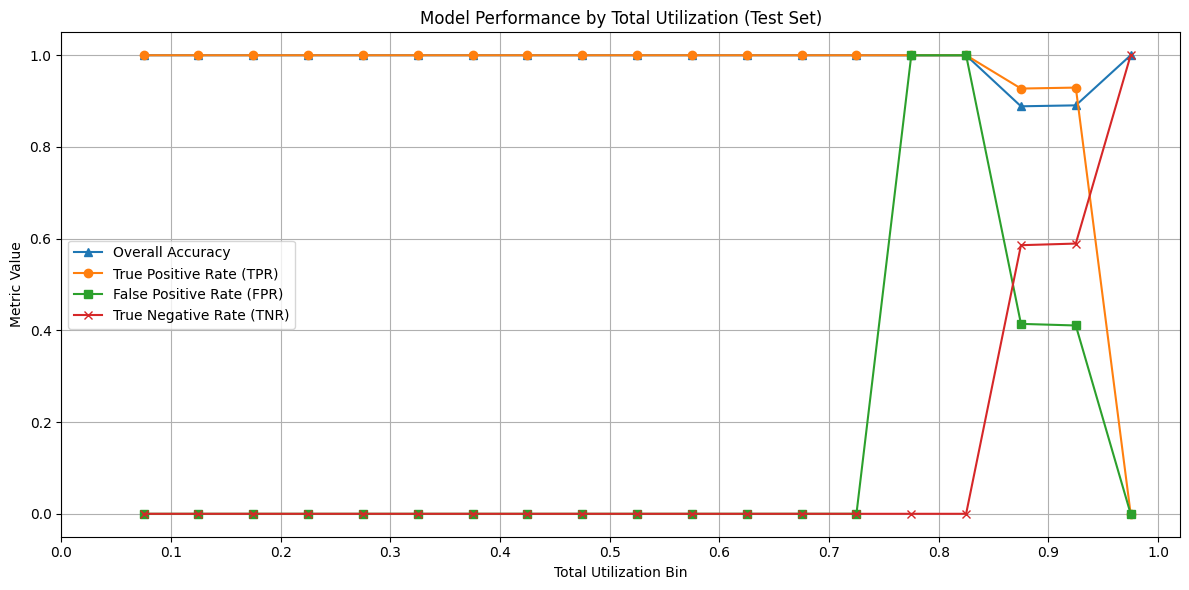

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import time # Import the time module

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    seed = 123
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    n_train, n_val, n_test = 100000, 80000, 100000
    train_ds = TasksetDataset(n_train, seed=seed)
    val_ds = TasksetDataset(n_val, seed=seed+1)
    test_ds = TasksetDataset(n_test, seed=seed+2)

    train_data_loader = DataLoader(
        train_ds,
        batch_size=128,
        shuffle=True,
        collate_fn=collate_tasksets_normalized
      )
    val_data_loader = DataLoader(
        val_ds,
        batch_size=128,
        shuffle=False,
        collate_fn=collate_tasksets_normalized
      )
    test_data_loader = DataLoader(
        test_ds,
        batch_size=128,
        shuffle=False,
        collate_fn=collate_tasksets_normalized
      )

    pos_weight = compute_pos_weight(train_ds)
    print("pos_weight:", pos_weight)

    model = SetTransformer(
        input_dim=3,
        dim=128,
        num_heads=4,
        num_inds=32,
        num_sab=2,
        pool_seeds=1,
        agg_dim=2
      )
    model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim,
        mode='max',
        factor=0.5,
        patience=3
      )
    best_val_f1 = 0.0
    best_path = "best_set_transformer.pt"

    start_time = time.time() # Start timer

    for epoch in range(1, 31):
      train_loss = train_epoch(model, train_data_loader, optim, device, pos_weight=pos_weight)
      val_metrics, _, _, _ = evaluate(model, val_data_loader, device)
      scheduler.step(val_metrics["f1"])

      print(f"Epoch {epoch:02d}  TrainLoss: {train_loss:.4f}  ValF1: {val_metrics['f1']:.4f}  ValAcc: {val_metrics['accuracy']:.4f}")

      if val_metrics["f1"] > best_val_f1:
          best_val_f1 = val_metrics["f1"]
          torch.save(model.state_dict(), best_path)

    end_time = time.time() # End timer
    total_time = end_time - start_time

    # Convert total_time to hours, minutes, and seconds
    hours = int(total_time // 3600)
    minutes = int((total_time % 3600) // 60)
    seconds = total_time % 60
    print(f"Total execution time: {hours}h {minutes}m {seconds:.2f}s")

    # evaluate on test set
    model.load_state_dict(torch.load(best_path, map_location=device))
    test_metrics, ys_test, preds_test, all_aggs_test = evaluate(model, test_data_loader, device)
    print("Test metrics:", test_metrics)

    # Call the plotting function
    plot_metrics_by_utilization(ys_test, preds_test, all_aggs_test)

if __name__ == "__main__":
    main()